# Text classification with an RNN



This short text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis. This exercise classifies movie reviews as positive or negative using the text of the review. So, this is an example of utilizing RNNs for binary classification.

We'll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

In [ ]:
# Priyadarshini Krishna Shobha, 3441064, st169614@stud.uni-stuttgart.de

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.



In [3]:
### download the dataset using TFDS (https://www.tensorflow.org/datasets). The dataset comes with an inbuilt subword tokenizer. 

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteH2UM5H/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteH2UM5H/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteH2UM5H/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


As this is a subwords tokenizer, it can be passed any string and the tokenizer will tokenize it.

A tokenizer breaks down sentences into word representations. It then converts each word into a suitable word vector (word embedding) which is a very efficient representation that is to be fed to the LSTM layers.

In [4]:
tokenizer = info.features['text'].encoder

In [5]:
# print the Vocabulary size of the dataset

print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


In [6]:
# test the encoding/decoding format of an example string

sample_string = 'RNNs are a cool DL framework.'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [8011, 8007, 8007, 8, 29, 4, 1690, 7997, 3780, 2692, 431, 7975]
The original string: RNNs are a cool DL framework.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [7]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

8011 ----> R
8007 ----> N
8007 ----> N
8 ----> s 
29 ----> are 
4 ----> a 
1690 ----> cool 
7997 ----> D
3780 ----> L 
2692 ----> frame
431 ----> work
7975 ----> .


Let us try to visualize our training data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let us print a trianing example.

In [8]:
train_examples_batch, train_labels_batch = next(iter(train_dataset.batch(1)))
train_examples_batch

<tf.Tensor: shape=(1, 163), dtype=int64, numpy=
array([[  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
        5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
           3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
          79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
          33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
          27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
          19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
         102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
           3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
           2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
         102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
          27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
          12,  258, 2306,   13,   91,   29,  171,   52,  229,   

Let us also print the corresponding label

In [9]:
train_labels_batch

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
# batch and suffle the data
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


## Create the model

Build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the Keras model to configure the training process using the appropriate loss function and the adam optimizer. The main metric of intrest for compilation should be the accuracy of classification:

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 59s 152ms/step - loss: 0.5514 - accuracy: 0.7143 - val_loss: 0.4871 - val_accuracy: 0.7790
Epoch 2/10
391/391 [==============================] - 59s 151ms/step - loss: 0.4376 - accuracy: 0.8085 - val_loss: 0.5731 - val_accuracy: 0.6888
Epoch 3/10
391/391 [==============================] - 60s 152ms/step - loss: 0.4525 - accuracy: 0.7864 - val_loss: 0.6839 - val_accuracy: 0.5735
Epoch 4/10
391/391 [==============================] - 61s 156ms/step - loss: 0.4789 - accuracy: 0.7868 - val_loss: 0.5506 - val_accuracy: 0.7291
Epoch 5/10
391/391 [==============================] - 62s 159ms/step - loss: 0.3745 - accuracy: 0.8447 - val_loss: 0.5073 - val_accuracy: 0.7911
Epoch 6/10
391/391 [==============================] - 63s 162ms/step - loss: 0.3208 - accuracy: 0.8726 - val_loss: 0.4714 - val_accuracy: 0.7956
Epoch 7/10
391/391 [==============================] - 63s 162ms/step - loss: 0.2863 - accuracy: 0.8870 - val_loss: 0.4996 - val_ac

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 19s 48ms/step - loss: 0.4967 - accuracy: 0.8217
Test Loss: 0.4967329800128937
Test Accuracy: 0.8217200040817261


The above model does not mask the padding applied to the sequences. This can lead to skewness if we train on padded sequences and test on un-padded sequences. Ideally the model would learn to ignore the padding, but as you can see below it does have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [16]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [17]:
def sample_predict(sentence, pad):
  tokenized_sample_pred_text = tokenizer.encode(sample_pred_text)

  if pad:
    tokenized_sample_pred_text = pad_to_size(tokenized_sample_pred_text, 64)

  predictions = model.predict(tf.expand_dims(tokenized_sample_pred_text, 0))

  return (predictions)

In [18]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.77170175]]


In [19]:
# predict on a sample text with padding
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.78937215]]


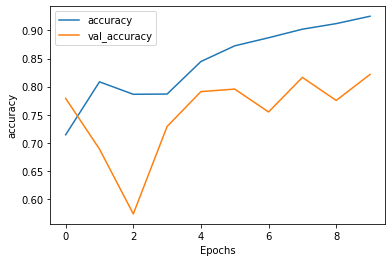

In [20]:
plot_graphs(history, 'accuracy')

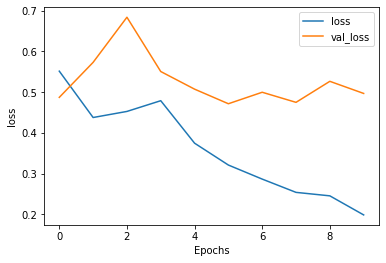

In [21]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [22]:
# redefine the model by stacking two or more LSTM layers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 104s 267ms/step - loss: 0.5333 - accuracy: 0.7297 - val_loss: 0.4455 - val_accuracy: 0.8177
Epoch 2/10
391/391 [==============================] - 106s 271ms/step - loss: 0.4995 - accuracy: 0.7634 - val_loss: 0.5001 - val_accuracy: 0.7741
Epoch 3/10
391/391 [==============================] - 105s 268ms/step - loss: 0.3663 - accuracy: 0.8480 - val_loss: 0.4006 - val_accuracy: 0.8210
Epoch 4/10
391/391 [==============================] - 104s 266ms/step - loss: 0.2501 - accuracy: 0.9019 - val_loss: 0.3355 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 104s 266ms/step - loss: 0.1989 - accuracy: 0.9255 - val_loss: 0.3736 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 105s 268ms/step - loss: 0.1547 - accuracy: 0.9458 - val_loss: 0.3661 - val_accuracy: 0.8627
Epoch 7/10
391/391 [==============================] - 104s 265ms/step - loss: 0.1189 - accuracy: 0.9621 - val_loss: 0.4028 -

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 33s 86ms/step - loss: 0.5022 - accuracy: 0.8623
Test Loss: 0.5021922588348389
Test Accuracy: 0.862280011177063


In [26]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.02403523]]


In [27]:
# predict on a sample text with padding
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.01461776]]


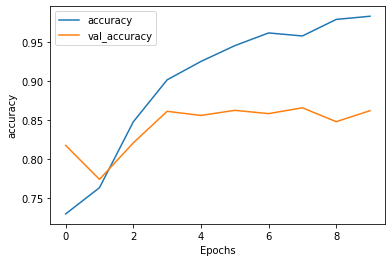

In [28]:
plot_graphs(history, 'accuracy')

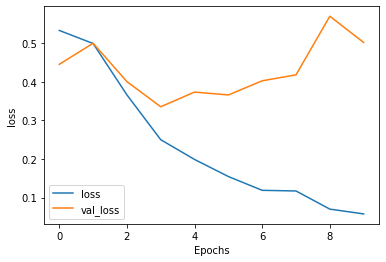

In [29]:
plot_graphs(history, 'loss')